## Import packages

In [1]:

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
from config import opt
from models import FlowersFcModel
from utils import train_model, get_val_metrics, get_images_paths, get_train_test_split, show_tensor_images, init_seeds
from datasets import FlowersDataset
from datasets.preprocessing import train_transformations_without_norm, val_transformations_without_norm

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [3]:
init_seeds(opt.seed)

## Prepare dataset

In [4]:
num_classes = len(set(opt.idx_to_class.keys()))

In [5]:
data_df = get_images_paths(opt=opt)
train_df, val_df = get_train_test_split(df=data_df, opt=opt)

In [6]:
data_df.label.value_counts()

4    602
0    518
2    472
3    420
1    239
Name: label, dtype: int64

In [7]:
train_dataset = FlowersDataset(
    img_paths=train_df['path'].values.copy(),
    labels=train_df['label'].values.copy(),
    num_classes=num_classes,
    transform=train_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

val_dataset = FlowersDataset(
    img_paths=val_df['path'].values.copy(),
    labels=val_df['label'].values.copy(),
    num_classes=num_classes,
    transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

val_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

## Training

In [8]:
next(iter(val_dataloader))['image'].shape

torch.Size([32, 1542])

In [9]:
in_features = 1542
hidden_dim = in_features  # // 2
model = FlowersFcModel(
    in_features=in_features, hidden_dim=hidden_dim, num_classes=num_classes
).to(opt.device)
# model.freeze_middle_layers()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

In [10]:
summary(model, input_size=(in_features, ), batch_size=opt.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 3084]       4,758,612
              ReLU-2                 [32, 3084]               0
       BatchNorm1d-3                 [32, 3084]           6,168
           Dropout-4                 [32, 3084]               0
            Linear-5                 [32, 3084]       9,514,140
              ReLU-6                 [32, 3084]               0
       BatchNorm1d-7                 [32, 3084]           6,168
           Dropout-8                 [32, 3084]               0
            Linear-9                  [32, 192]         592,320
             ReLU-10                  [32, 192]               0
      BatchNorm1d-11                  [32, 192]             384
           Linear-12                    [32, 5]             965
Total params: 14,878,757
Trainable params: 14,878,757
Non-trainable params: 0
-------------------------

In [11]:
train_model(model, optimizer, scheduler, criterion, train_dataloader, val_dataloader, opt, target_metric='f1_avg', best_target_metric=-np.inf)

Epoch: [0][ 0/57]	Time 11.062 (11.062)	Data 10.967 (10.967)	Loss 1.9226e+00 (1.9226e+00)	Acc   0.16 (  0.16)	F1   0.17 (  0.17)
Epoch: [0][10/57]	Time  0.096 ( 2.789)	Data  0.002 ( 2.702)	Loss 1.4968e+00 (1.7721e+00)	Acc   0.44 (  0.23)	F1   0.41 (  0.22)
Epoch: [0][20/57]	Time 10.212 ( 2.951)	Data 10.125 ( 2.867)	Loss 1.4749e+00 (1.6820e+00)	Acc   0.34 (  0.27)	F1   0.33 (  0.26)
Epoch: [0][30/57]	Time  0.226 ( 2.656)	Data  0.148 ( 2.572)	Loss 1.6266e+00 (1.6526e+00)	Acc   0.31 (  0.28)	F1   0.32 (  0.26)
Epoch: [0][40/57]	Time  8.889 ( 2.699)	Data  8.803 ( 2.615)	Loss 1.5120e+00 (1.6254e+00)	Acc   0.34 (  0.29)	F1   0.31 (  0.27)
Epoch: [0][50/57]	Time  0.202 ( 2.563)	Data  0.078 ( 2.477)	Loss 1.5495e+00 (1.6098e+00)	Acc   0.28 (  0.29)	F1   0.21 (  0.27)
Val: [ 0/57]	Time 10.995 (10.995)	Loss 1.5828e+00 (1.5828e+00)	Acc   0.09 (  0.09)	F1   0.06 (  0.06)
Val: [10/57]	Time  0.018 ( 2.717)	Loss 1.5819e+00 (1.5661e+00)	Acc   0.06 (  0.21)	F1   0.01 (  0.10)
Val: [20/57]	Time  9.248 ( 2

## Model performance metrics

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
model = FlowersFcModel(
    in_features=in_features, hidden_dim=hidden_dim, num_classes=num_classes
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'))
model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [14]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_dataloader, model, opt.device)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 57/57 [02:43<00:00,  2.87s/it]

Accuracy: 0.467
F1: 0.451
Precision: 0.47
Recall: 0.467


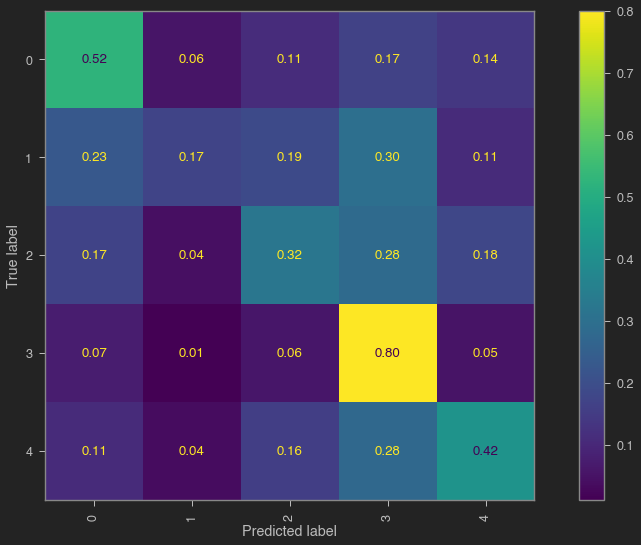

In [15]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

## Inference

In [16]:
from utils.loops import infer_folder, infer_one_file

In [17]:
image_path = '../data/daisy/10712722853_5632165b04.jpg'
infer_one_file(
    image_path, model, opt.device, transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features, features_type=opt.features_type
)

0

In [18]:
folder_path = '../data/daisy'
result = infer_folder(
    folder_path, model, opt.device, image_ext='jpg',
    transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type
)
result[:5]

[('../data/daisy/14167534527_781ceb1b7a_n.jpg', 4),
 ('../data/daisy/476857510_d2b30175de_n.jpg', 0),
 ('../data/daisy/521762040_f26f2e08dd.jpg', 0),
 ('../data/daisy/7320089276_87b544e341.jpg', 1),
 ('../data/daisy/721595842_bacd80a6ac.jpg', 2)]